In [63]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(0, "./../")
import json
import utils
import torch

from FileManager import FileManager

plt.rc("figure", dpi=120, facecolor=(1, 1, 1))
plt.rc("font", family="Times New Roman", size=12)
plt.rc("axes", facecolor=(1, .99, .95), titlesize=12)
plt.rc("mathtext", fontset='cm')
plt.rcParams['figure.dpi'] = 200

# Spectra of matrices

In [2]:
VOCAB_SZ = 10_000

data_dir = os.path.join(os.getenv("DATASETPATH"), "qwem")
data_fm = FileManager(data_dir)

analogy_dict = data_fm.load("analogies.pickle")
if analogy_dict is None:
    raise FileNotFoundError("Analogy file not found.")

data_fm.set_filepath("min500")
word_counts = data_fm.load("word_counts.pickle")

vocab = utils.Vocabulary(word_counts[:VOCAB_SZ])
unigram = vocab.counts / vocab.counts.sum()

analysis_fm = FileManager("../analysis")
Mstar_eigvals = analysis_fm.load("mstar-eigvals.npy")

In [7]:
corpus_stats = data_fm.load("corpus_stats.pickle")
cL = corpus_stats["context_len"]
Cij, Crwij = corpus_stats["counts"], corpus_stats["counts_reweight"]
numcounts = Cij[:VOCAB_SZ, :VOCAB_SZ].sum()
Pij = Crwij[:VOCAB_SZ, :VOCAB_SZ] / (numcounts * (cL + 1)/2)
PiPj = np.outer(unigram, unigram)

print("Eigsolving PMI...")
PMI = np.log((Pij / PiPj) + 1e-25)
PMI = torch.tensor(PMI, dtype=torch.float64).cuda()
PMI_eigvals = torch.linalg.eigvalsh(PMI).cpu().numpy()
PMI_eigvals = PMI_eigvals[::-1]

print("Eigsolving PPMI...")
PPMI = PMI.clamp(min=0)
PPMI_eigvals = torch.linalg.eigvalsh(PPMI).cpu().numpy()
PPMI_eigvals = PPMI_eigvals[::-1]

print("Eigsolving Gij...")
Gij = Pij / PiPj + 1
Gij = torch.tensor(Gij, dtype=torch.float64).cuda()
Gij_eigvals = torch.linalg.eigvalsh(Gij).cpu().numpy()
Gij_eigvals = Gij_eigvals[::-1]

Eigsolving PPMI...
Eigsolving Gij...


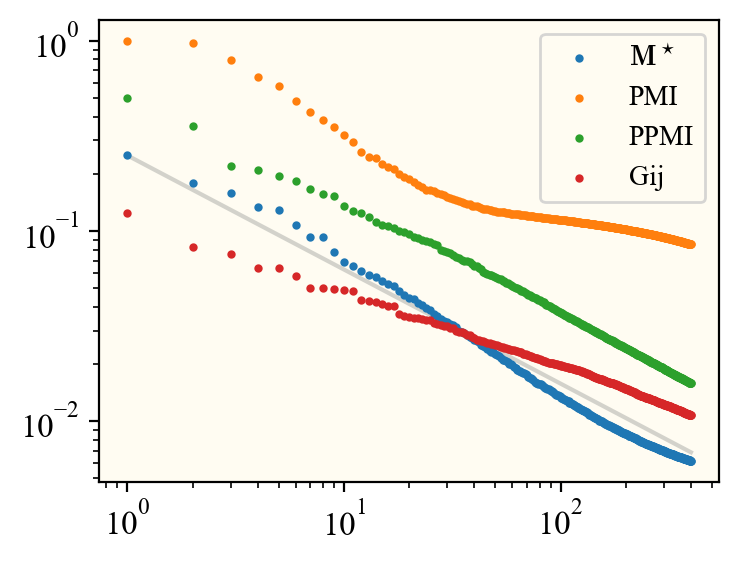

In [40]:
fig, ax = plt.subplots(figsize=(4,3))

max_idx = 400
idxs = 1 + np.arange(max_idx)
f = Mstar_eigvals.max()**(-1.)
ax.scatter(idxs, .25*f*Mstar_eigvals[:max_idx], s=4, label=f"$\\mathbf{{M}}^\\star$")
f = PMI_eigvals.max()**(-1.)
ax.scatter(idxs, f*PMI_eigvals[:max_idx], s=4, label="PMI")
f = PPMI_eigvals.max()**(-1.)
ax.scatter(idxs, .5*f*PPMI_eigvals[:max_idx], s=4, label="PPMI")

f = Gij_eigvals.max()**(-1.)
ax.scatter(idxs, .125*f*Gij_eigvals[:max_idx], s=4, label="Gij")

ax.plot(idxs, .25*idxs**(-.6), color="xkcd:gray", alpha=0.4, zorder=-3)

ax.legend(fontsize=10)
ax.set_xscale("log")
ax.set_yscale("log")

plt.show()

# Eigen-features overlap

In [42]:
data_dir = os.path.join(os.getenv("DATASETPATH"), "qwem")
data_fm = FileManager(data_dir)

analogy_dict = data_fm.load("analogies.pickle")
if analogy_dict is None:
    raise FileNotFoundError("Analogy file not found.")

data_fm.set_filepath("min500")
word_counts = data_fm.load("word_counts.pickle")

In [ ]:
expt_dir = "C:/Users/dkark/Documents/Research/QWEM/stepwise-sgns"
fm = FileManager(expt_dir)
with open(fm.get_filename("hypers.json")) as f:
    H = json.load(f)

VOCAB_SZ = H["vocab_sz"]
EMBEDDIM = H["embeddim"]
vocab = utils.Vocabulary(word_counts[:VOCAB_SZ])
unigram = vocab.counts / vocab.counts.sum()
analogy_dataset = utils.AnalogyDataset(analogy_dict, vocab)

save_fm = FileManager('../analysis/bench_models')
models = save_fm.load(f"models_d{EMBEDDIM}_V{VOCAB_SZ}.pickle")
if models is None:
    print("TODO: create and save models.")

In [102]:
W_SGNS = models["SGNS"]
W_QWEM = models["QWEM"]
W_PPMI = models["PPMI"]

V_SGNS, _, _ = np.linalg.svd(W_SGNS, full_matrices=False)
V_QWEM, _, _ = np.linalg.svd(W_QWEM, full_matrices=False)
V_PPMI, _, _ = np.linalg.svd(W_PPMI, full_matrices=False)
Oq = V_SGNS.T @ V_QWEM
Op = V_SGNS.T @ V_PPMI

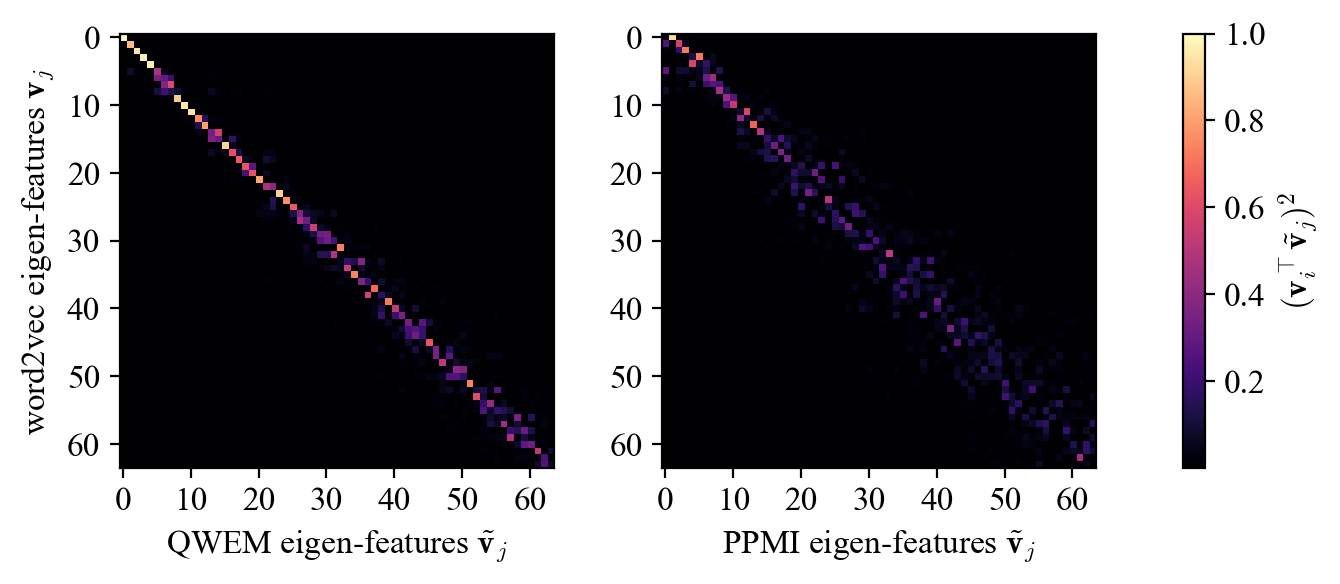

In [103]:
fig = plt.figure(figsize=(7, 3))
gs = fig.add_gridspec(100, 100, wspace=0, hspace=0)
axes = [
    fig.add_subplot(gs[:, 0:40]),
    fig.add_subplot(gs[:, 50:90]),
]
cbar_ax = fig.add_subplot(gs[:, 90:])
cbar_ax.axis('off')
cbar_ax.tick_params(axis='both', labelleft=False)


dmax = 64

for i, ax in enumerate(axes):
    O = [Oq, Op][i]
    cax = ax.matshow(O[:dmax, :dmax]**2, cmap='magma', vmax=1)

    ax.xaxis.set_ticks_position('bottom')
    if i == 0:
        ax.set_xlabel(f'QWEM eigen-features $\\tilde\\mathbf{{v}}_j$')
        ax.set_ylabel(f'word2vec eigen-features $\\mathbf{{v}}_j$')
    else:
        ax.set_xlabel(f'PPMI eigen-features $\\tilde\\mathbf{{v}}_j$')

cbar = fig.colorbar(cax, ax=cbar_ax, orientation='vertical', fraction=.2, pad=-.8)
cbar.set_label(f"$(\\mathbf{{v}}_i^\\top \\tilde\\mathbf{{v}}_j)^2$")

plt.savefig('fig5.pdf', format='pdf', bbox_inches='tight')

# Linrep RMT, other classes

In [104]:
VOCAB_SZ = 10_000

data_dir = os.path.join(os.getenv("DATASETPATH"), "qwem")
data_fm = FileManager(data_dir)

analogy_dict = data_fm.load("analogies.pickle")
if analogy_dict is None:
    raise FileNotFoundError("Analogy file not found.")

data_fm.set_filepath("min500")
word_counts = data_fm.load("word_counts.pickle")

vocab = utils.Vocabulary(word_counts[:VOCAB_SZ])
unigram = vocab.counts / vocab.counts.sum()
analogy_dataset = utils.AnalogyDataset(analogy_dict, vocab)

analysis_fm = FileManager("../analysis")
eigvecs = analysis_fm.load("mstar-eigvecs.npy")
eigvals = analysis_fm.load("mstar-eigvals.npy")

In [105]:
category2name = {
    "capital-common-countries": "country-capital",
    "capital-world": "country-capital-2",
    "currency": "country-currency",
    "city-in-state": "city-state",
    "family": "male-female",
    "gram1-adjective-to-adverb": "adj-adverb",
    "gram2-opposite": "adj-antonym",
    "gram3-comparative": "adj-comparative",
    "gram4-superlative": "adj-superlative",
    "gram5-present-participle": "verb-participle",
    "gram6-nationality-adjective": "country-nationality",
    "gram7-past-tense": "verb-preterite",
    "gram8-plural": "noun-plural",
    "gram9-plural-verbs": "verb-plural"
}
catname2category = {v:k for k,v in category2name.items()}

for category, category_analogies in analogy_dataset.analogies.items():
    if category != "full":
        npairs = len(analogy_dataset.pairs[category])
        print(f"{category2name[category]:<25} {npairs:>2} pairs\t {len(category_analogies):>4} analogies")
    else:
        print(f"Total: {len(category_analogies)} analogies")
print()


country-capital           19 pairs	  342 analogies
country-capital-2         38 pairs	 1406 analogies
country-currency           6 pairs	   30 analogies
city-state                39 pairs	 1482 analogies
male-female               16 pairs	  240 analogies
adj-adverb                18 pairs	  306 analogies
adj-antonym                6 pairs	   30 analogies
adj-comparative           21 pairs	  420 analogies
adj-superlative           14 pairs	  182 analogies
verb-participle           23 pairs	  506 analogies
country-nationality       35 pairs	 1190 analogies
verb-preterite            27 pairs	  702 analogies
noun-plural               23 pairs	  506 analogies
verb-plural               17 pairs	  272 analogies
Total: 7614 analogies



In [106]:
def get_R(W, family):
    pairs = analogy_dataset.pairs[catname2category[family]]
    a = np.array([a for a, _ in pairs])
    b = np.array([b for _, b in pairs])
    R = W[b] - W[a]
    return R

W = eigvecs[:, :4096] @ np.diag(np.sqrt(eigvals[:4096]))

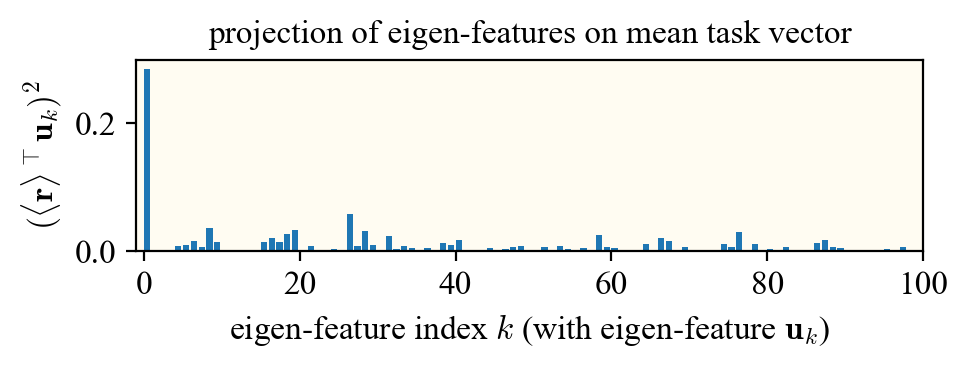

In [188]:
from matplotlib.patches import FancyArrowPatch

def set_mp_plot(ax, R, fudge, height):

    def estim_sigma2(R_d):
        R_d = R_d - R_d.mean(axis=0, keepdims=True)
        sigma2 = np.mean(R_d**2)
        return sigma2

    def estim_d_eff(R_d, outliers=0):
        n, d = R_d.shape
        sigma2 = estim_sigma2(R_d)
        Rcent = R_d - R_d.mean(axis=0, keepdims=True)
        C = (Rcent @ Rcent.T) / d
        eigva = np.linalg.eigvalsh(C)
        upper = eigva[-(1+outliers)]
        gamma_est = (np.sqrt(upper / sigma2) - 1)**2
        d_eff = n / gamma_est
        return d_eff

    def mp_distro(lam, N, d, sigma2=0.01):
        gamma = N/d
        lam_scaled = lam / sigma2
        lb = (1 - np.sqrt(gamma))**2
        ub = (1 + np.sqrt(gamma))**2
        density = np.zeros_like(lam)
        support = (lam_scaled >= lb) & (lam_scaled <= ub)
        density[support] = np.sqrt((ub - lam_scaled[support]) * (lam_scaled[support] - lb)) / (2 * np.pi * gamma * lam_scaled[support])
        return density / sigma2
    
    d = 256    

    xmax = .2
    xx = np.linspace(0, xmax, 1000)

    N = R.shape[0]
    R_d = R[:, :d]
    eigvals = np.linalg.eigvalsh((1/d) * R_d @ R_d.T)
    sigma2 = estim_sigma2(R_d)
    d_eff = estim_d_eff(R_d, outliers=1)
    d_eff *= fudge

    counts, bins, _ = ax.hist(eigvals, bins=int(300*xmax), range=(0, xmax),
                                    color="xkcd:azure", alpha=0.6,
                                    label=f"$d={d}$")
    idx = np.where(counts > 0)[0][-1]
    ax.add_patch(FancyArrowPatch((bins[idx]+.0017, 4), (bins[idx]+.0017, 1.2), mutation_scale=10, arrowstyle="->",
                                color="xkcd:azure", shrinkA=0, shrinkB=0, lw=2))


    th = mp_distro(xx, N, d_eff, sigma2=sigma2)
    th *= height * counts.max()/(th.max()+1e-15)
    mp_color = "xkcd:tangerine"
    ax.fill_between(xx, th, color=mp_color, alpha=0.5, zorder=-4)
    ax.plot(xx, th, color=mp_color, alpha=1, lw=1, zorder=-4,
            label=f"$d_\\mathrm{{eff}}={d_eff:.1f}$")

    ax.set_xlim(0, xmax)
    ax.set_ylim(0, 11)
    ax.set_title(f"spectra of $\\mathbf{{R}}_d\\mathbf{{R}}_d^\\top$")

    ax.legend(fontsize=9)

    ax.set_xlabel("eigenvalue")
    ax.set_ylabel("counts")

def set_localization_plot(ax, R):
    
    d = 100
    R_d = R[:, :d]
    N, d = R_d.shape
    mean = R_d.T @ (np.ones(N) / N)
    power = mean**2
    power /= power.sum()

    ax.bar(np.arange(d), power, align="edge")
    ax.set_xlabel(f"eigen-feature index $k$ (with eigen-feature $\\mathbf{{u}}_k$)")
    ax.set_ylabel(f"$(\\langle \\mathbf{{r}}\\rangle^\\top \\mathbf{{u}}_k)^2$")
    ax.set_title(f"projection of eigen-features on mean task vector",
                fontsize=12)
    ax.set_xlim(-1, d)


families = ["male-female", "adj-adverb", "noun-plural", "adj-comparative"]
fudges = [.75, .75, .8, .6]
heights = [1.1, 1.1, .9, 1.1]

category = catname2category[family]
R = get_R(W, family)
fig, ax = plt.subplots(figsize=(5,2))
# set_mp_plot(ax, R, fudge, height)
set_localization_plot(ax, R)
plt.tight_layout()
plt.show()

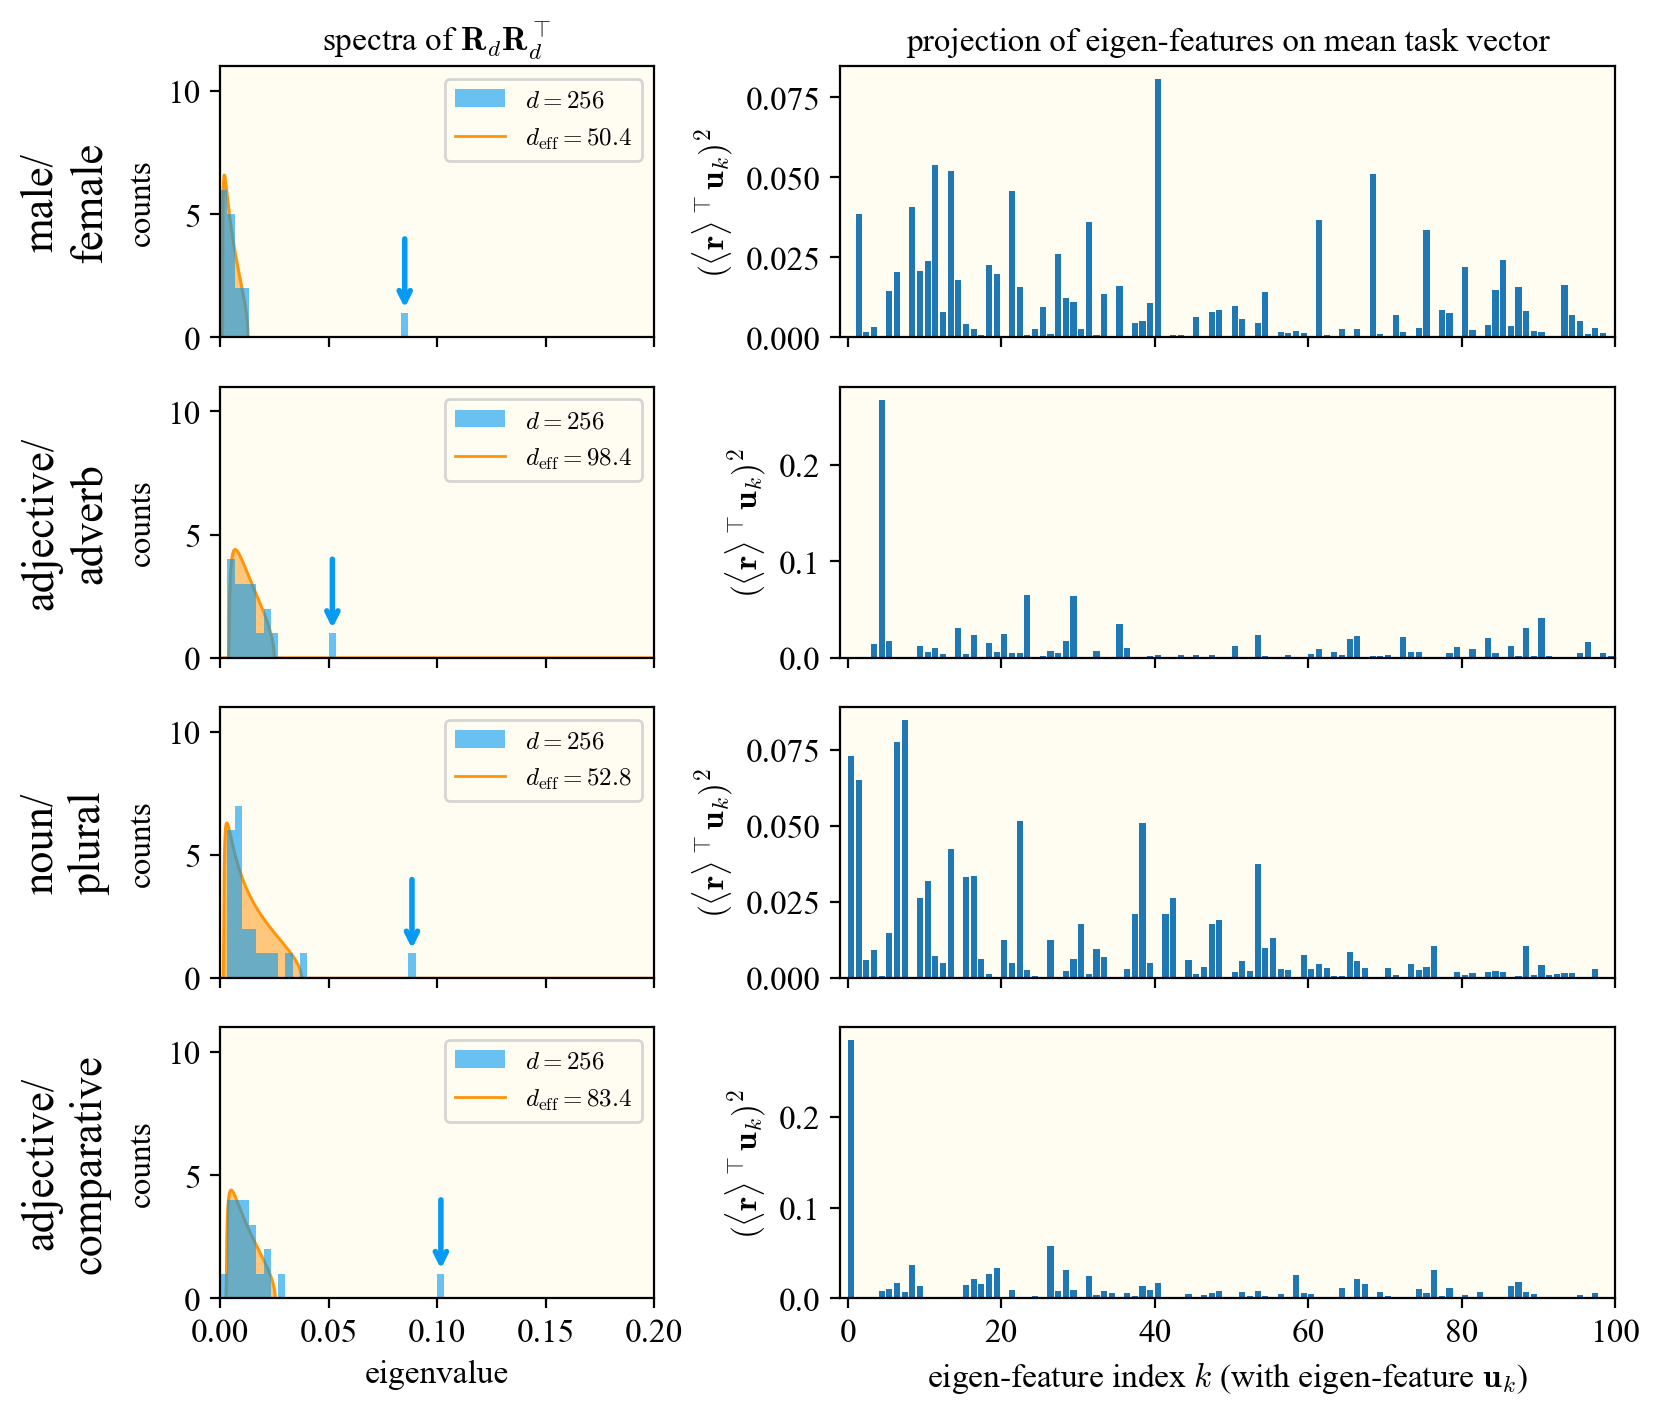

In [194]:
labels = ["male/\nfemale", "adjective/\nadverb", "noun/\nplural", "adjective/\ncomparative"]
families = ["male-female", "adj-adverb", "noun-plural", "adj-comparative"]
fudges = [.75, .75, .8, .6]
heights = [1.1, 1.1, .9, 1.1]

fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(100, 100, wspace=0, hspace=0)
rslices = [slice(0, 22), slice(26, 48), slice(52, 74), slice(78, 100)]
cslices = [slice(0, 5), slice(10, 38), slice(50, 100)]

axes = []
for i, rslice in enumerate(rslices):
    row = [
        fig.add_subplot(gs[rslice, cslices[1]]),
        fig.add_subplot(gs[rslice, cslices[2]]),
    ]
    axes.append(row)

    ax_label = fig.add_subplot(gs[rslice, cslices[0]])
    ax_label.axis("off")
    ax_label.text(0., 0.5, labels[i], fontsize=16, ha='center', va='center', rotation=90)

for i, row in enumerate(axes):
    ax_rmt, ax_ipr = row
    family = families[i]
    R = get_R(W, family)
    set_mp_plot(ax_rmt, R, fudges[i], heights[i])
    set_localization_plot(ax_ipr, R)
    if i != 3:
        for ax in row:
            ax.tick_params(axis='x', labelbottom=False)
            ax.set_xlabel(None)
    if i != 0:
        for ax in row:
            ax.set_title(None)
    

plt.savefig('fig6.pdf', format='pdf', bbox_inches='tight')

# IPR

In [ ]:
VOCAB_SZ = 10_000

data_dir = os.path.join(os.getenv("DATASETPATH"), "qwem")
data_fm = FileManager(data_dir)

analogy_dict = data_fm.load("analogies.pickle")
if analogy_dict is None:
    raise FileNotFoundError("Analogy file not found.")

data_fm.set_filepath("min500")
word_counts = data_fm.load("word_counts.pickle")

vocab = utils.Vocabulary(word_counts[:VOCAB_SZ])
unigram = vocab.counts / vocab.counts.sum()
analogy_dataset = utils.AnalogyDataset(analogy_dict, vocab)

analysis_fm = FileManager("../analysis")
eigvecs = analysis_fm.load("mstar-eigvecs.npy")
eigvals = analysis_fm.load("mstar-eigvals.npy")

In [ ]:
EMBEDDIM = 200
topd_eigvals, topd_eigvecs = eigvals[:EMBEDDIM], eigvecs[:, :EMBEDDIM]
topd_Mstar = topd_eigvecs @ np.diag(topd_eigvals) @ topd_eigvecs.T
W_QWEM = topd_eigvecs @ np.diag(np.sqrt(topd_eigvals))

print(f"shape(W) = {W_QWEM.shape}")
print(f"QWEM acc: {100*analogy_dataset.eval_accuracy(W_QWEM):.1f}%")

In [ ]:
category2name = {
    "capital-common-countries": "country-capital",
    "capital-world": "country-capital-2",
    "currency": "country-currency",
    "city-in-state": "city-state",
    "family": "male-female",
    "gram1-adjective-to-adverb": "adj-adverb",
    "gram2-opposite": "adj-antonym",
    "gram3-comparative": "adj-comparative",
    "gram4-superlative": "adj-superlative",
    "gram5-present-participle": "verb-participle",
    "gram6-nationality-adjective": "country-nationality",
    "gram7-past-tense": "verb-preterite",
    "gram8-plural": "noun-plural",
    "gram9-plural-verbs": "verb-plural"
}
catname2category = {v:k for k,v in category2name.items()}

for category, category_analogies in analogy_dataset.analogies.items():
    if category != "full":
        npairs = len(analogy_dataset.pairs[category])
        print(f"{category2name[category]:<25} {npairs:>2} pairs\t {len(category_analogies):>4} analogies")
    else:
        print(f"Total: {len(category_analogies)} analogies")
print()

In [ ]:
W = eigvecs[:, :4096] @ np.diag(np.sqrt(eigvals[:4096]))

def get_R(W, family):
    pairs = analogy_dataset.pairs[catname2category[family]]
    a = np.array([a for a, _ in pairs])
    b = np.array([b for _, b in pairs])
    R = W[b] - W[a]
    return R

In [ ]:
def IPR(power):
    power = power / power.sum()
    return (power**2).sum()

# family = "verb-preterite"
family = "male-female"
# family = "adj-adverb"
# families = "adj-antonym"
# family = "city-state"
# family = "country-nationality"
# family = "adj-comparative"
# family = "country-currency"
category = catname2category[family]
R =get_R(W, family)

dd = np.logspace(2, 12, 41, base=2).astype(int)
IPRs = np.empty_like(dd).astype(float)
flats = np.empty_like(dd).astype(float)
for i, d in enumerate(dd):
    R_d = R[:, :d]
    N, d = R_d.shape
    mean = R_d.T @ (np.ones(N) / N)
    power = mean**2
    flat = 1 + power*0
    IPRs[i] = IPR(power)
    flats[i] = IPR(flat)

plt.plot(dd, IPRs)
plt.plot(dd, dd**-.58)
plt.yscale("log")
plt.xscale("log")
plt.show()